In [25]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
%matplotlib inline
import pandas as pd

In [26]:
voltage = 400 #nominal_voltage
battery_volumn = 60 * 1000 / 400 # Q = kWh / v
emission_max_value = 100
start_soc = 0.216
end_soc = 0.7
target_charge_volumn = (end_soc - start_soc) *battery_volumn
Power = 10 * 1000 # power of the charger
I_max = Power  / voltage
R = 0.1 # resistance
Power_limit = 10 * 1000 # simple assumption to the limit of the power: 100 kw
Power_limit_slope_line_Intercept = 50 * 1000 # simple assumption to the limit of the power(the sloped line): 100 kw

In [27]:
step = 1/6 # 10(min)/ 60(min)

In [28]:
maximum_steps = 24 / step # 24 hours divided by step

In [29]:
x = np.linspace(0, int(maximum_steps), int(maximum_steps+1))
emission_array = emission_max_value/((maximum_steps/2)**2) * (x-(maximum_steps/2))**2

In [30]:
current_state = cp.Variable(int(maximum_steps+1),'current at each step')
P = cp.Variable(int(maximum_steps+1),'power of the charger at each step')
soc = cp.Variable(int(maximum_steps+1),"state of charge")
voltage = cp.Variable(int(maximum_steps+1),"voltage")


objective = cp.Minimize( cp.sum(P*emission_array))
constraints = []

# constraint on voltage
for i in range(0,int(maximum_steps+1)):
    constraints += [voltage[i] == 400]

# constraint on the relationship between I and P
for i in range(0,int(maximum_steps+1)):
    constraints += [P[i] == 2*R*current_state[i] + 400 * current_state[i]]

constraints += [soc[0] == start_soc]

# SOC update formula
for i in range(1,int(maximum_steps+1)):
    constraints += [soc[i] == soc[i-1] +current_state[i-1]*step/ battery_volumn]

# Second part of power limit (inclined line)
for i in range(0,int(maximum_steps+1)):
    constraints += [P[i] <= Power_limit_slope_line_Intercept*(1- soc[i])] 
# first part of power limit (straight line)
for i in range(0,int(maximum_steps+1)):
    constraints += [P[i] <= Power_limit] 

constraints += [ cp.sum(current_state)*step >= (target_charge_volumn)]
constraints += [P <= Power]
constraints += [P >= 0]

problem = cp.Problem(objective, constraints)
result = problem.solve()
print(result)
P_values = P.value
P_values = [value if value>=1 else 0 for value in P_values ]
print(P_values)

/home/yihua/anaconda3/lib/python3.10/site-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 4 times so far.

  warnings.warn(msg, UserWarning)


85464.82872632875
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2096.0570672353388, 9999.99999857715, 9999.999999304058, 9999.999999816437, 9999.99999983276, 9999.999999820286, 9999.999999832537, 9999.999999853328, 9999.999999870237, 9999.999999877482, 9999.999999873178, 9999.999999858232, 9999.99999983631, 9999.999999813588, 9999.999999791293, 9999.9999997133, 9999.999999264146, 9999.999999465232, 2231.0629310318013, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [31]:
I_values = [(-400 + np.sqrt(400*400 + 8*R*P))/(4*R) for P in P_values]
print(I_values)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.2264845974646335, 24.695076592488476, 24.69507659426185, 24.695076595511978, 24.695076595551768, 24.695076595521357, 24.695076595551342, 24.695076595601932, 24.695076595643286, 24.695076595660908, 24.69507659565039, 24.69507659561401, 24.695076595560437, 24.695076595505014, 24.695076595450587, 24.695076595260304, 24.695076594164505, 24.695076594655063, 5.562188357915119, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

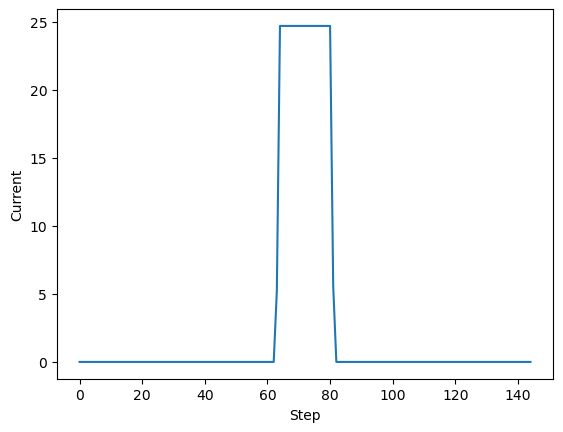

In [32]:
x = np.array([i for i in range(len(P_values))])
plt.figure()
plt.plot(x, I_values)
plt.xlabel("Step")
plt.ylabel("Current")

plt.show()